In [13]:
# Jack Highton, 30/07/2024

In [14]:
import numpy as np
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import onnx

from datetime import datetime, timedelta
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, balanced_accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

In [15]:
# Set SQLite database location
data_location = r'C:\Users\jackAdmin\sensor_data\data.db'
# Set location to save model in ONNX format 
onnx_save_location = r'C:\Users\jackAdmin\sensor_model\random_forest_for_occupancy_classification_with_sensor_data.onnx'

In [16]:
# Query the SQLite database to create pandas DataFrames

# connect to the SQLite database
connect = sqlite3.connect(data_location)

# get table containing home ids and multiple_occupancy label
df_homes = pd.read_sql_query("SELECT * FROM homes", connect)

# get table containing detections data for all homes
df_motion = pd.read_sql_query("SELECT * FROM motion", connect)

# show the number of unique homes present in the detections dataset 
# (note: some home ids in the homes table do not have corresponding data in the detections dataset. These will not be included in the model.)
print('number of homes with detections data:')
print(df_motion['home_id'].nunique())

# show list of the room catagories present in the detections dataset
print('\nroom catagories present in the detections dataset:')
print(df_motion['location'].unique())

# show the extracted tables
print('')
print(df_homes)
print(df_motion)


number of homes with detections data:
50

room catagories present in the detections dataset:
['lounge' 'bedroom1' 'hallway' 'kitchen' 'bathroom1' 'WC1' 'living room'
 'dining room' 'conservatory' 'study']

                                   id  multiple_occupancy
0    dc922bd9bf8a2a9437642fe0dce9dcaa                   0
1    d40fc88629271da7b5833ed3f3222d17                   1
2    3fb064da180f02862063eca8e3b609c0                   1
3    16d71b9c46d9abd765bf395818efe527                   0
4    458264665736fd26184a8ea5641e6c48                   1
..                                ...                 ...
101  dbe580ed60d7c329931d98a0e2ad0ea3                   1
102  04a16138cd7e0fa768858ff7c02856d8                   1
103  62c8145530aca30cb0455dc386c0a9d6                   1
104  3a5cc5ac41ab3b18b63d6d8366e30fb0                   1
105  3a1f53e2e242bff03301a250135f894b                   0

[106 rows x 2 columns]
                                      id                           home_id

In [17]:
# Function to count detections in different rooms occuring within a given timeframe.
# The reasoning for engineering this application specific feature is that in homes with multiple occupancy detections in different rooms in a 
# small time window should be more common than in single occupancy homes, because of residents being active in different rooms.
def count_detections_within_timeframe(df, timeframe):
    
    count = 0
    previous_row = None
    # iterate through the rows of detections
    for index, row in df.iterrows():
        # if there is a previous detection, find time since previous detection in seconds
        if previous_row is not None:
            
            row_dt = datetime.fromisoformat(row['datetime'])
            row_seconds = row_dt.hour * 3600 + row_dt.minute * 60 + row_dt.second
            
            prev_row_dt = datetime.fromisoformat(previous_row['datetime'])
            prev_row_seconds = prev_row_dt.hour * 3600 + prev_row_dt.minute * 60 + prev_row_dt.second
            
            time_diff = row_seconds - prev_row_seconds
            
            # if time since the previous detection is below the timeframe threshold, add 1 to the count
            if time_diff <= timeframe and row['location'] != previous_row['location']:
                count += 1
                
        previous_row = row
        
    return count

In [18]:
# Function to get mean time (within a 24hr day) and the standard deviation of detection times 
def get_time_distribution(df):

    # Create list of detection times converted to seconds, where 00.00am is at 0 seconds
    sec_list = []
    for index, row in df.iterrows():

        row_dt = datetime.fromisoformat(row['datetime'])
        row_seconds = row_dt.hour * 3600 + row_dt.minute * 60 + row_dt.second
        sec_list.append(row_seconds)

    # Find the mean and standard deviation 
    mean_secs = np.nanmean(np.array(sec_list))
    std_secs = np.nanstd(np.array(sec_list))

    return mean_secs, std_secs


In [19]:
# Create an empty DataFrame with the feature column names
column_names = ['home_id', 'multiple_occupancy', 'no_events', 'no_events_per_rooms', 'no_rooms', 'time_mean', 'time_std',
                'no_crossroom_0s', 'no_crossroom_1s', 'no_crossroom_10s', 'lounge', 'bedroom1', 'hallway', 'kitchen', 
                'bathroom1', 'WC1', 'living room', 'dining room', 'conservatory', 'study']
df_features = pd.DataFrame(columns=column_names)

# Interate through the rows in the homes dataframe, find corresponding detections data, and produce features
for index, row in df_homes.iterrows():

    # Get home id and occupancy label
    home_id = row['id']
    label = row['multiple_occupancy']

    # Get home id and occupancy label
    df_home_motion = df_motion[df_motion['home_id'] == home_id]

    # If there is no detector data for the home, continue to next home without including it in model training and testing
    if len(df_home_motion) == 0:
        continue

    # Feature Extraction

    # Total number of detection events 
    no_events = len(df_home_motion)
    # Number of rooms in the house 
    no_rooms = df_home_motion['location'].nunique()
    # Number of events per room
    no_event_per_room = int( round(no_events / max(no_rooms,1)) )
    # Mean and standard deviation of detection times (in seconds starting from 00:00am)
    tmean, tstd = get_time_distribution(df_home_motion)
    # Number of times that detections occur in two different rooms within 0, 1, and 10 second timeframes as a fraction of the number of events.
    # The reasoning for this application specific feature is that in homes with multiple occupancy detections in different rooms in a small time
    # window should be more common than in single occupancy homes, because of residents being active in different rooms.
    no_dets_t0 = count_detections_within_timeframe(df_home_motion, timeframe=0) /no_events
    no_dets_t1 = count_detections_within_timeframe(df_home_motion, timeframe=1) /no_events
    no_dets_t10 = count_detections_within_timeframe(df_home_motion, timeframe=10) /no_events

    # Create row for the features dataframe
    # This includes the features defined above and the fraction of events seen in each type of room
    new_row = {
        'home_id': home_id, 
        'multiple_occupancy': label,
        'no_events': no_events, 
        'no_rooms': no_rooms, 
        'no_events_per_rooms': no_event_per_room,
        'time_mean': tmean,
        'time_std': tstd,
        'no_crossroom_0s': no_dets_t0,
        'no_crossroom_1s': no_dets_t1,
        'no_crossroom_10s': no_dets_t10,
        'lounge' : len(df_home_motion[df_home_motion['location']=='lounge'])/no_events,
        'bedroom1': len(df_home_motion[df_home_motion['location']=='bedroom1'])/no_events,
        'hallway': len(df_home_motion[df_home_motion['location']=='hallway'])/no_events,
        'kitchen': len(df_home_motion[df_home_motion['location']=='kitchen'])/no_events,
        'bathroom1': len(df_home_motion[df_home_motion['location']=='bathroom1'])/no_events,
        'WC1': len(df_home_motion[df_home_motion['location']=='WC1'])/no_events,
        'living room': len(df_home_motion[df_home_motion['location']=='living room'])/no_events,
        'dining room': len(df_home_motion[df_home_motion['location']=='dining room'])/no_events,
        'conservatory': len(df_home_motion[df_home_motion['location']=='conservatory'])/no_events,
        'study': len(df_home_motion[df_home_motion['location']=='study'])/no_events,
    }

    # Add row to the features dataframe
    df_features.loc[len(df_features)] = new_row

# Show features dataframe
print(df_features)


                             home_id  multiple_occupancy  no_events  \
0   16d71b9c46d9abd765bf395818efe527                   0       6780   
1   83740365903618c9bec6c786ce5643e9                   1      18250   
2   a3b30fd4c2ba426cc01de5ce8adcdcae                   1      11617   
3   20a3ebd4470c712d6f6d99908d931e09                   0       7166   
4   37b99328702f9fdc68c431a4ac450f2e                   0       5286   
5   930874c7cb4c0a68e876a6b5b044d22a                   1      14946   
6   205c42ec747e2db13cb92087a99433f1                   1      16191   
7   31c4eba2695cea9bec8abf0bf56bdc6b                   1      11390   
8   7d0c35e6c50b2c266742fd87e8d5f427                   1       5756   
9   c026d3469f489d341ab145bd62d00796                   0      22658   
10  3b57a456d431b64da3485c6aedfc13c1                   1      17372   
11  ddc8427426a01a1835cbaf56d87fb265                   1      10827   
12  2739e3f7409068a94cf6e3eac643c2e7                   1      20501   
13  f5

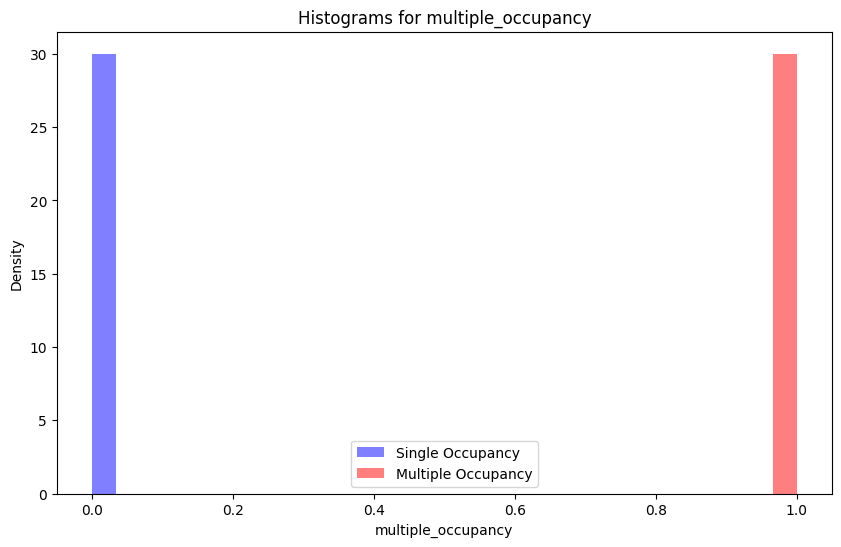

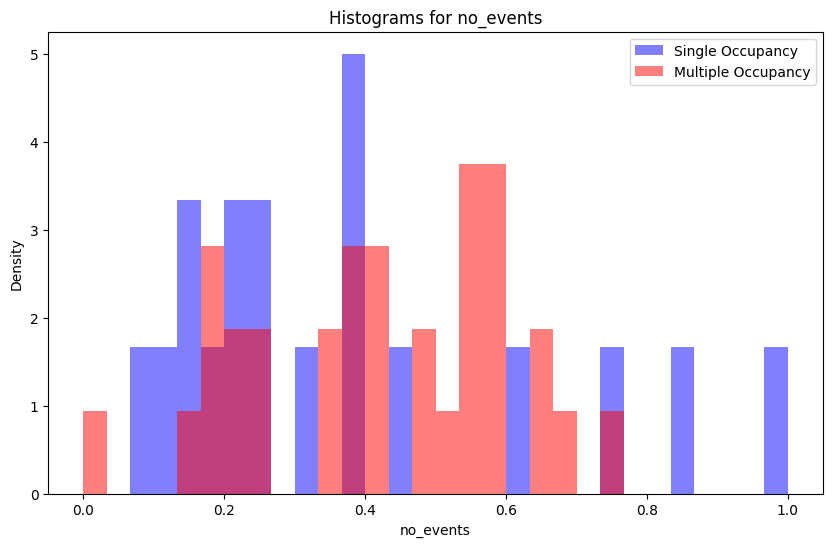

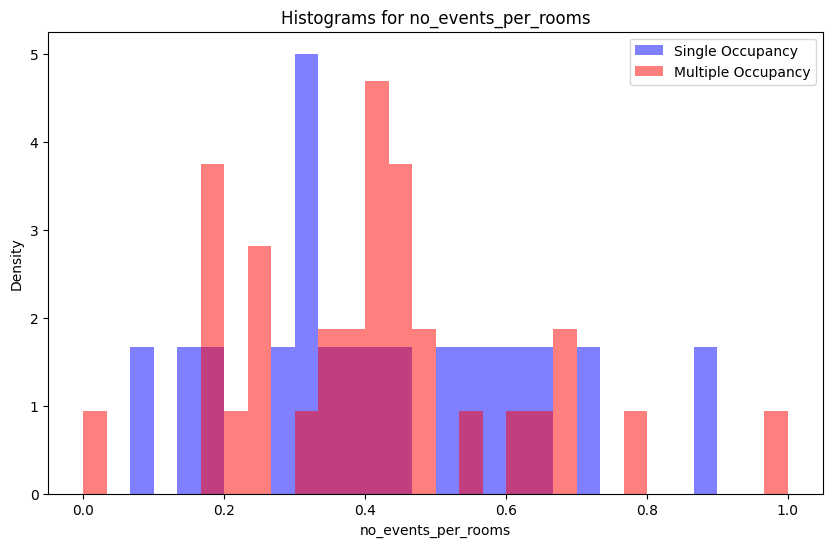

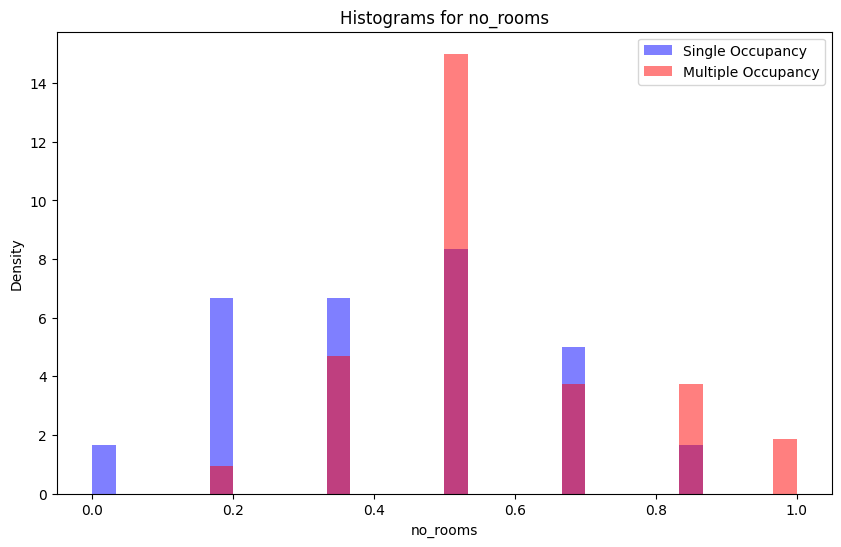

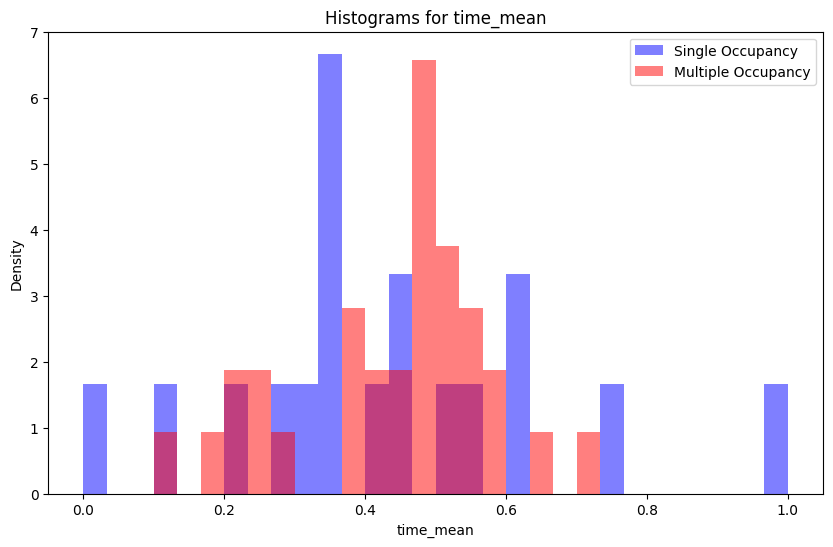

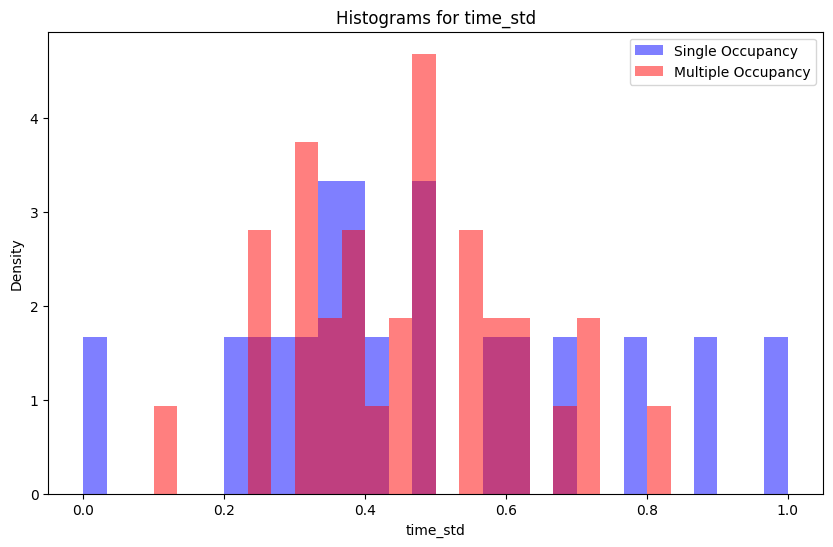

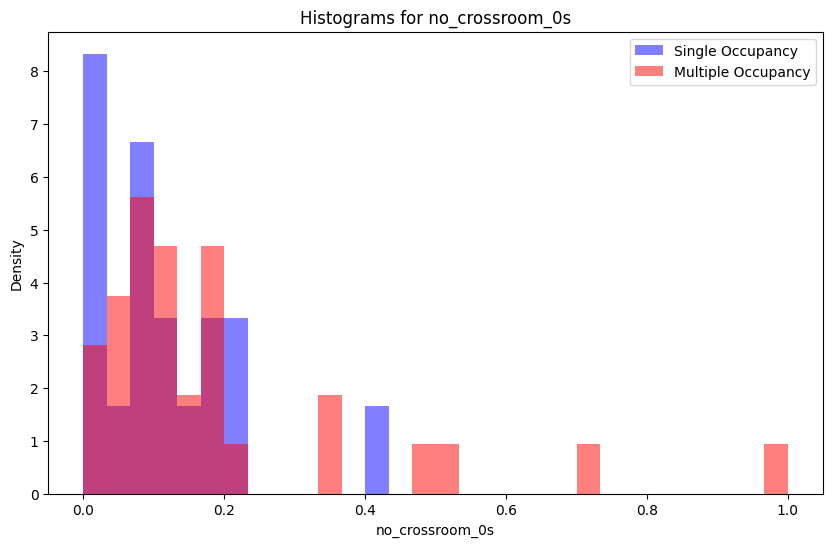

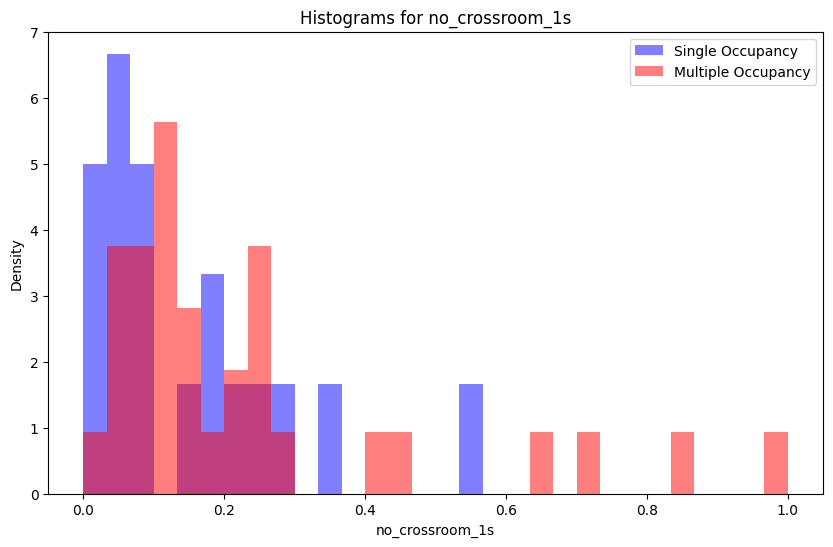

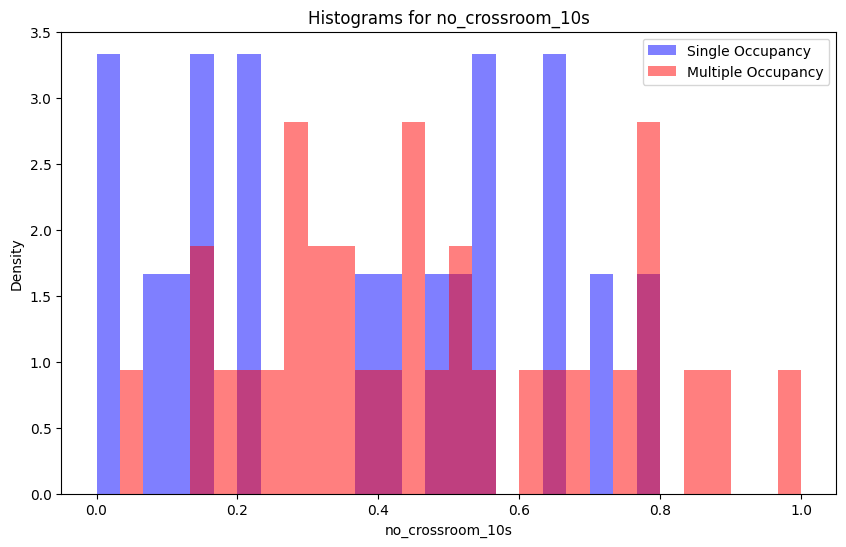

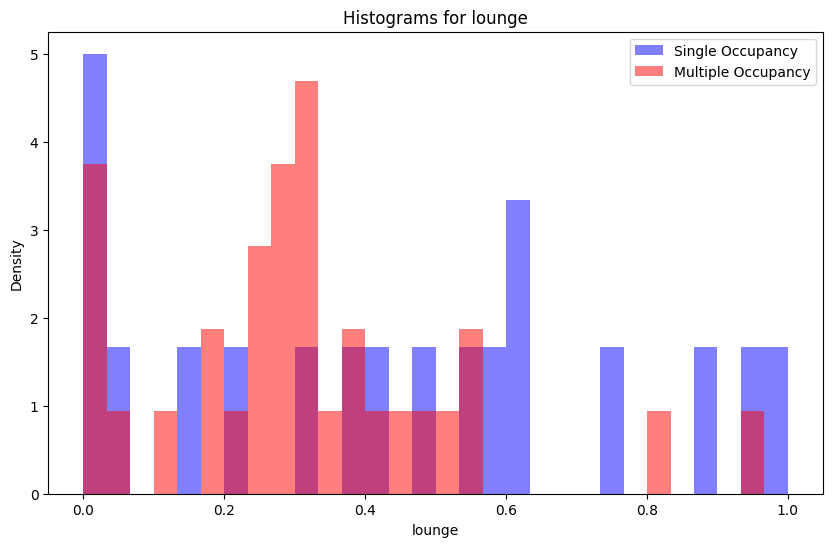

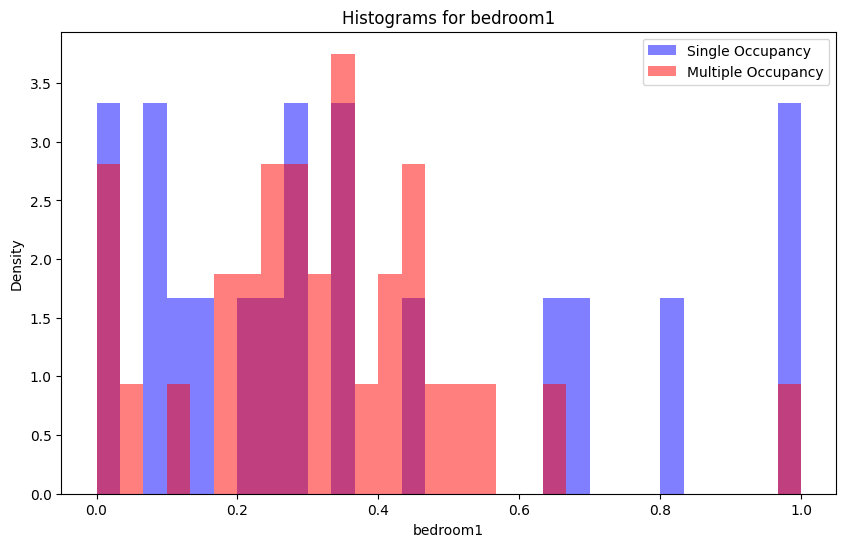

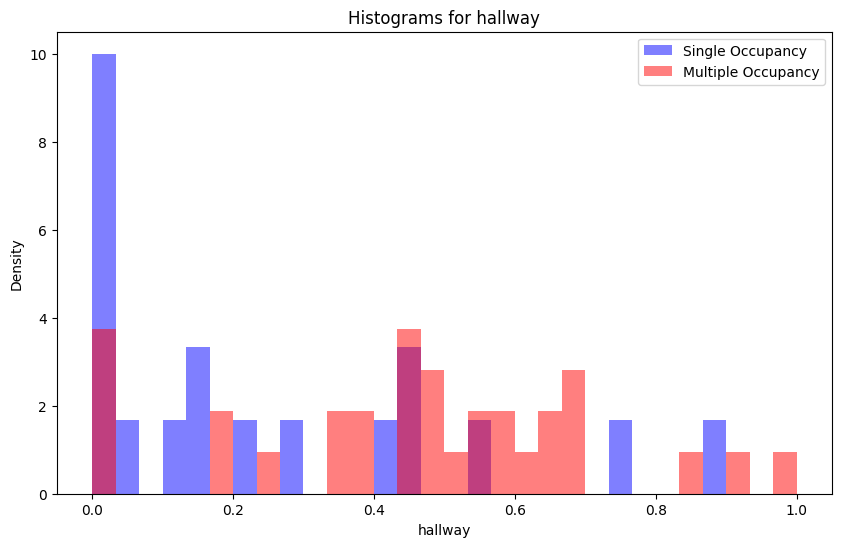

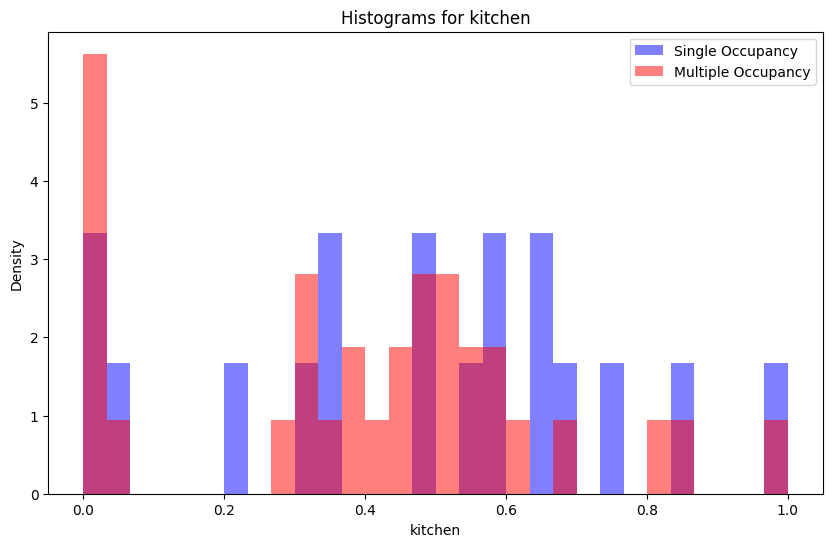

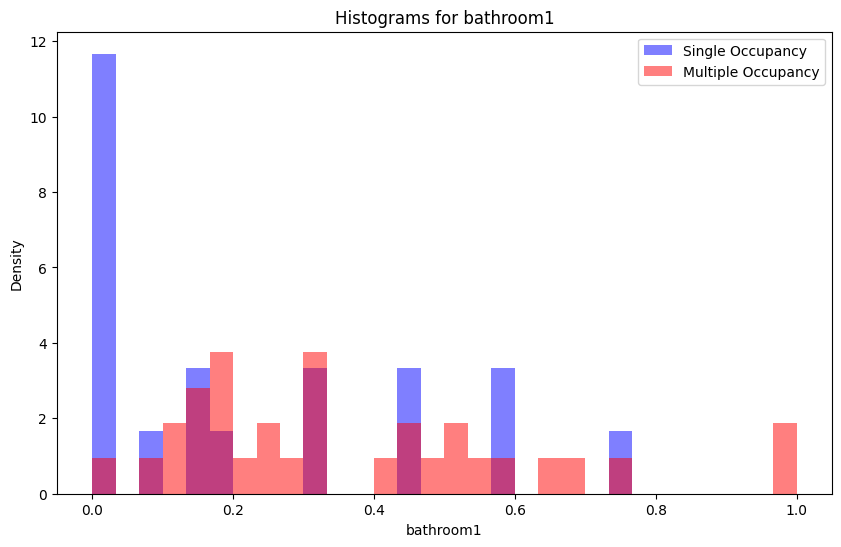

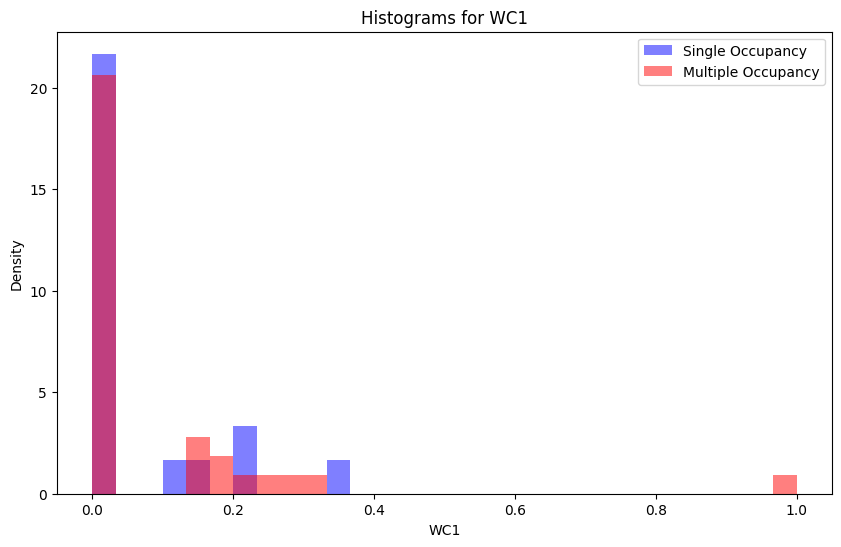

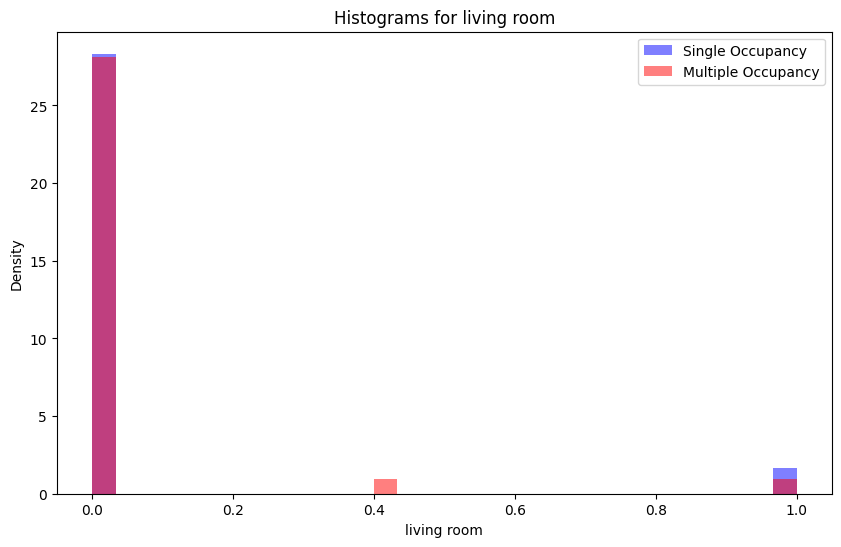

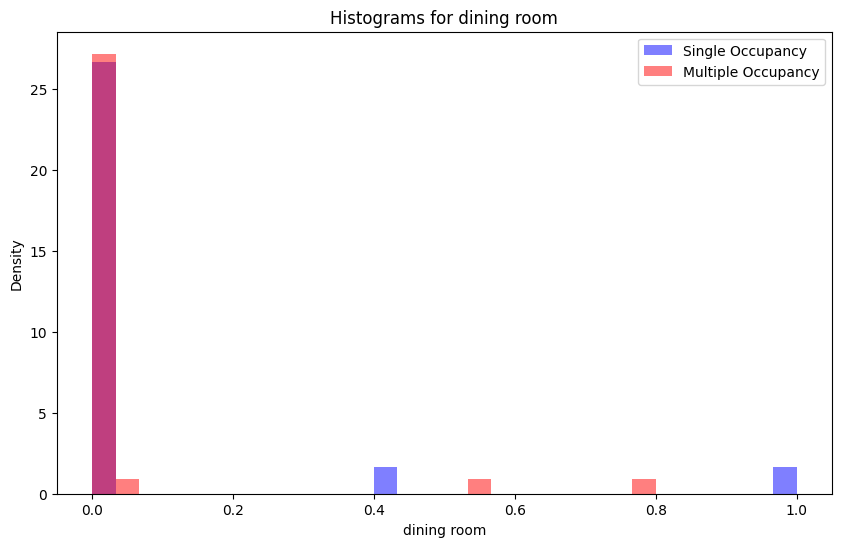

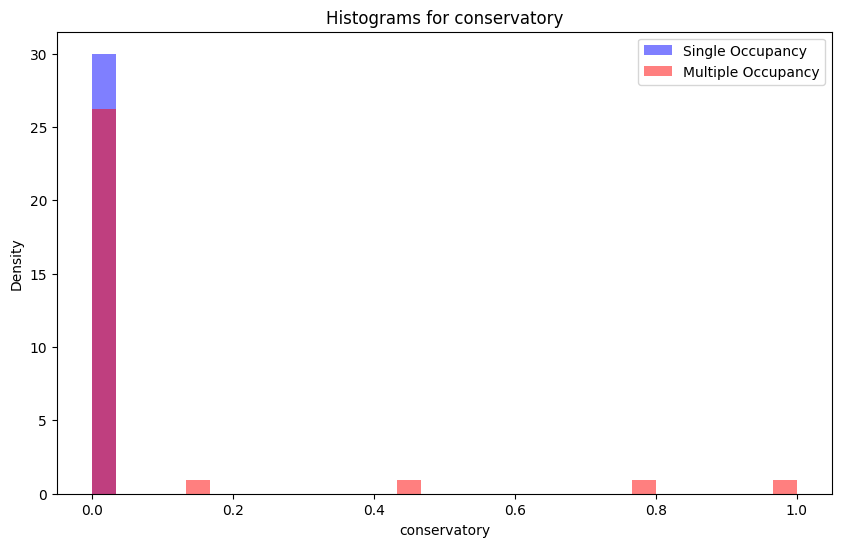

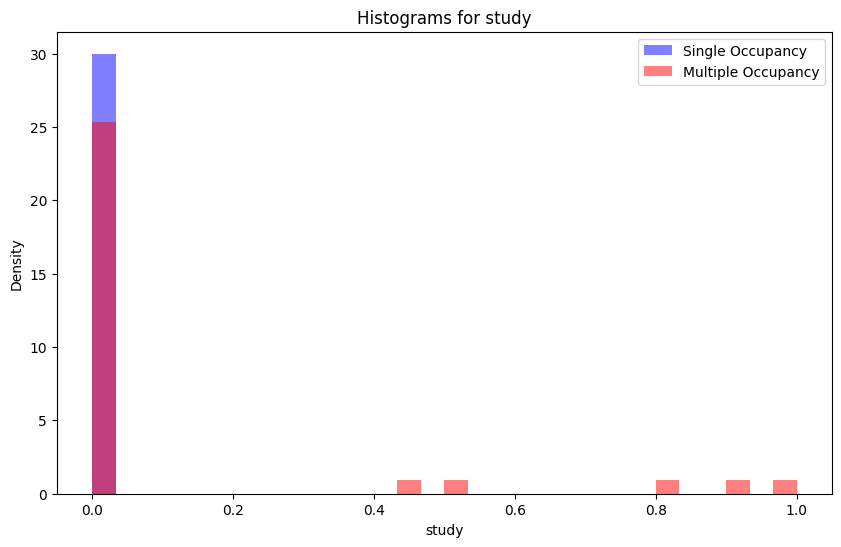

In [20]:
# Show distribution of each extracted feature for the whole dataset, with overlapping histograms 

# remove id column and convert data to floats
df_features_hist = df_features.drop(columns=['home_id'])
df_features_hist = df_features_hist.astype(float)
# normalise the features into a range between 0 and 1 
df_features_scaled = (df_features_hist - df_features_hist.min()) / (df_features_hist.max() - df_features_hist.min())
# get list of feature column names 
features = df_features_scaled.columns

# iterate through the features 
for feature in features:
    # for each feature, get values for the two classes 
    feature_data_0 = df_features_scaled[df_features_scaled['multiple_occupancy'] == 0][feature]  
    feature_data_1 = df_features_scaled[df_features_scaled['multiple_occupancy'] == 1][feature]  
    # choose bin edges, assuring that the histogram bars for the two classes have the same width 
    num_bins = 30
    bin_edges_0 = np.linspace(feature_data_0.min(), feature_data_0.max(), num_bins + 1)
    bin_edges_1 = np.linspace(feature_data_1.min(), feature_data_1.max(), num_bins + 1)
    bin_edges_2 = np.linspace(0, 1, num_bins + 1)

    # plot the overlapping histogram
    plt.figure(figsize=(10, 6))
    plt.hist(feature_data_0, bins=bin_edges_2, alpha=0.5, label='Single Occupancy', color='blue', density=True)
    plt.hist(feature_data_1, bins=bin_edges_2, alpha=0.5, label='Multiple Occupancy', color='red', density=True)
    plt.title(f'Histograms for {feature}')
    plt.xlabel(feature)
    plt.ylabel('Density') 
    plt.legend()
    plt.show()

In [21]:
# remove id column and convert data to floats
df_features_01 = df_features.drop(columns=['home_id'])
df_features_01 = df_features_01.astype(float)
# normalise the features into a range between 0 and 1 
df_features_01 = (df_features_01 - df_features_01.min()) / (df_features_01.max() - df_features_01.min())

# The features Dataframe, with 'ground truth' removed 
X = df_features_01.drop(columns=['multiple_occupancy'])

# The 'ground truth' label vector 
y = df_features_01['multiple_occupancy']

# Split the features Dataframe into training dataset (65% of homes) and test dataset (35% of homes)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=0, shuffle=True)

# Train the random forest classifier model, with class weights inversly proportional to their number to address class imbalance 
model = RandomForestClassifier(class_weight='balanced', random_state=0)

# Fit model to training dataset
model.fit(X_train, y_train)

# Make predictions using test dataset
y_pred = model.predict(X_test)

# Evaluate the model

# Absolute accuarcy 
accuracy = accuracy_score(y_test, y_pred)
# Balanced accuarcy. This is the mean accuarcy for both occupancy classes in the test dataset.   
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
# Confusion matrix. First row: True Positive, False Positive. Second row: False Negative, True Negative
conf_matrix = confusion_matrix(y_test, y_pred)

# Area Under Reciver Operating Characteristic curve (AUROC)
y_prob = model.predict_proba(X_test)[:, 1]
auroc = roc_auc_score(y_test, y_prob)

# Print evaluation results
# (the following values were obtained)
#absolute accuracy:
#0.778
#balanced accuracy:
#0.723
#AUROC:
#0.685

print('confusion matrix:')
print(conf_matrix)
print('\nabsolute accuracy:')
print(accuracy)
print('\nbalanced accuracy:')
print(balanced_accuracy)
print('\nAUROC:')
print(auroc)


confusion matrix:
[[ 3  2]
 [ 2 11]]

absolute accuracy:
0.7777777777777778

balanced accuracy:
0.7230769230769231

AUROC:
0.6846153846153846


In [22]:
# Package the model in ONNX format

# define the initial type, then convert sklearn random forest model to onnx 
initial_type = [('float_input', FloatTensorType([None, X_train.shape[1]]))]
onnx_model = convert_sklearn(model, initial_types=initial_type)

# save the onnx model 
onnx.save_model(onnx_model, onnx_save_location)